In [1]:
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

es = Elasticsearch(['127.0.0.1'], port=9200, timeout=480)


In [2]:
successful_logon_query=es.search(index='winlogbeat-*', 
    body = {
        'size': 3000,
        'query': {
            'bool': {
               'must': [
                    {"match" : {'source_name': "Microsoft-Windows-Security-Auditing" }},
                    {"match": {'event_id': 4624}},
                    {"match": {'event_data.LogonType': 3}}
               ],
               'must_not': [
                    {"match" : {'event_data.IpAddress': "::1" }},
                    {"match": {'event_data.TargetUserName': "ANONYMOUS LOGON"}}
               ],
               "filter": [
                    {"range" : {"@timestamp" : {"gt": "now-30d", "lt" : "now"}}}
               ]    
            }

        }
    })

sysmon_network_query=es.search(index='winlogbeat-*', body = {
    'size': 3000,
    'query': {
        'bool': {
           'must': [
               {"match": {'source_name': 'Microsoft-Windows-Sysmon'}},
               {"match": {'event_id': 3}}
           ],
           'must_not': [
                {"match" : {'event_data.User': "NT AUTHORITY\SYSTEM"}}
           ],
           "filter": [
                {"range" : {"@timestamp" : {"gt": "now-30d", "lt" : "now"}}}
           ]    
        }
        
    }
})

In [3]:
sl_normalized=json_normalize(map(lambda x: x["_source"],successful_logon_query['hits']['hits']))

In [4]:
sn_normalized=json_normalize(map(lambda x: x["_source"],sysmon_network_query['hits']['hits']))

In [5]:
sl_df=sl_normalized[sl_normalized["event_data.IpAddress"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sl_df=sl_df[~sl_df['event_data.TargetUserName'].str.contains('.*\$')]
sl_df['user'] = sl_df['event_data.TargetDomainName'] + '\\' + sl_df['event_data.TargetUserName']
sl_df.rename(columns={"event_data.IpAddress":"sourceip", "computer_name":"target"}, inplace=True)
sl_df_clean=sl_df[['sourceip', 'target', 'user', '@timestamp']].reset_index(drop=True)
sl_df_clean.head(10)

,sourceip,target,user,@timestamp
0,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z
1,172.18.39.107,VA-WK-ACCT002.hf.com,HF\pdulce,2017-07-31T05:19:24.107Z
2,172.18.39.102,WK-VA-HR002.hf.com,HF\pdulce,2017-07-31T05:20:52.437Z
3,172.18.39.106,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.454Z
4,172.18.39.106,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.458Z
5,172.18.39.100,VA-WK-HR003.hf.com,HF\cbrown,2017-07-31T05:15:38.709Z
6,172.18.39.106,VA-WK-ACCT003.hf.com,HF\pdulce,2017-07-31T05:17:10.917Z
7,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.597Z
8,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.621Z
9,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.712Z


In [6]:
sn_df=sn_normalized[sn_normalized["event_data.SourceIp"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sn_df.rename(columns={"event_data.SourceHostname":"source","event_data.SourceIp":"sourceip", "event_data.DestinationIp":"targetip", "event_data.User":"user"}, inplace=True)
sn_df_clean=sn_df[['source', 'targetip', 'user', '@timestamp']]
sn_df_clean.reset_index(drop=True)
sn_df_clean.head(10)

,source,targetip,user,@timestamp
0,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:19:54.348Z
1,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:42.049Z
2,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:33.423Z
3,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:20:26.189Z
4,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:09.277Z
5,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:19.060Z
6,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:43.091Z
7,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:51.220Z
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:16.150Z
9,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:16:43.451Z


In [7]:
sysmon_ip_computer_reference=sn_df[['sourceip', 'computer_name']]
sysmon_ip_computer_reference = (sysmon_ip_computer_reference.drop_duplicates()).reset_index(drop=True)
sysmon_ip_computer_reference

,sourceip,computer_name
0,172.18.39.106,VA-WK-HR003.hf.com
1,172.18.39.105,WK-VA-HR002.hf.com
2,172.18.39.107,VA-WK-ACCT003.hf.com
3,172.18.39.100,VA-WK-HR001.hf.com
4,172.18.39.102,VA-WK-ACCT002.hf.com


In [8]:
sl_df_merged=pd.merge(sl_df_clean,sysmon_ip_computer_reference,how="left",left_on="sourceip",right_on="sourceip")
sl_df_merged.head(10)

,sourceip,target,user,@timestamp,computer_name
0,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR001.hf.com
1,172.18.39.107,VA-WK-ACCT002.hf.com,HF\pdulce,2017-07-31T05:19:24.107Z,VA-WK-ACCT003.hf.com
2,172.18.39.102,WK-VA-HR002.hf.com,HF\pdulce,2017-07-31T05:20:52.437Z,VA-WK-ACCT002.hf.com
3,172.18.39.106,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.454Z,VA-WK-HR003.hf.com
4,172.18.39.106,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.458Z,VA-WK-HR003.hf.com
5,172.18.39.100,VA-WK-HR003.hf.com,HF\cbrown,2017-07-31T05:15:38.709Z,VA-WK-HR001.hf.com
6,172.18.39.106,VA-WK-ACCT003.hf.com,HF\pdulce,2017-07-31T05:17:10.917Z,VA-WK-HR003.hf.com
7,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.597Z,VA-WK-HR001.hf.com
8,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.621Z,VA-WK-HR001.hf.com
9,172.18.39.100,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.712Z,VA-WK-HR001.hf.com


In [9]:
sn_df_merged=pd.merge(sn_df_clean,sysmon_ip_computer_reference,how="left",left_on="targetip",right_on="sourceip")
sn_df_merged.head(10)

,source,targetip,user,@timestamp,sourceip,computer_name
0,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:19:54.348Z,NaN,NaN
1,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:42.049Z,NaN,NaN
2,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:33.423Z,NaN,NaN
3,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:20:26.189Z,NaN,NaN
4,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:09.277Z,NaN,NaN
5,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:19.060Z,NaN,NaN
6,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:43.091Z,NaN,NaN
7,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:51.220Z,NaN,NaN
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:16.150Z,NaN,NaN
9,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:16:43.451Z,NaN,NaN


In [10]:
sl_df_resolved=sl_df_merged[['computer_name','target', 'user', '@timestamp']][sl_df_merged['computer_name'].notnull()]
sl_df_resolved.rename(columns={'computer_name':"source"}, inplace=True)
sl_df_resolved.reset_index(drop=True)
sl_df_resolved.head(10)

,source,target,user,@timestamp
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce,2017-07-31T05:19:24.107Z
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce,2017-07-31T05:20:52.437Z
3,VA-WK-HR003.hf.com,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.454Z
4,VA-WK-HR003.hf.com,HFDC01.hf.com,HF\cbrown,2017-07-31T05:28:48.458Z
5,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\cbrown,2017-07-31T05:15:38.709Z
6,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,2017-07-31T05:17:10.917Z
7,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.597Z
8,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.621Z
9,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.712Z


In [11]:
sn_df_merged.computer_name.fillna(sn_df_merged.targetip, inplace=True)
sn_df_resolved=sn_df_merged[['source','computer_name', 'user', '@timestamp']]
sn_df_resolved.rename(columns={'computer_name':'target'}, inplace=True)
sn_df_resolved.head(10)

,source,target,user,@timestamp
0,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:19:54.348Z
1,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:42.049Z
2,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:33.423Z
3,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:20:26.189Z
4,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:09.277Z
5,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:19.060Z
6,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:43.091Z
7,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:17:51.220Z
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:18:16.150Z
9,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:16:43.451Z


In [12]:
sl_sn_appended = sl_df_resolved.append(sn_df_resolved)
sl_sn_appended = sl_sn_appended[['source', 'target', 'user']]
sl_sn_appended = (sl_sn_appended.drop_duplicates()).reset_index(drop=True)
sl_sn_appended

,source,target,user
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce
3,VA-WK-HR003.hf.com,HFDC01.hf.com,HF\cbrown
4,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\cbrown
5,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce
6,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins
7,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce
9,VA-WK-ACCT003.hf.com,172.18.39.101,HF\pdulce


In [13]:
sl_sn_merged = pd.merge(sl_df_resolved,sn_df_resolved,how="left",left_on="target",right_on="source")
sl_sn_merged.head(10)

,source_x,target_x,user_x,@timestamp_x,source_y,target_y,user_y,@timestamp_y
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:19:54.348Z
1,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:20:26.189Z
2,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:19:05.007Z
3,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-08-09T18:20:22.878Z
4,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:16:26.589Z
5,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:16:34.341Z
6,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:16:41.091Z
7,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:17:03.091Z
8,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:17:10.341Z
9,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,2017-07-31T05:15:38.640Z,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,2017-07-31T05:17:14.342Z


In [14]:
sl_sn_merged['@timestamp_x'] = pd.to_datetime(sl_sn_merged['@timestamp_x'])
sl_sn_merged['@timestamp_y'] = pd.to_datetime(sl_sn_merged['@timestamp_y'])

sl_sn_merged = sl_sn_merged[sl_sn_merged.apply(lambda x: (x['@timestamp_y'] - x['@timestamp_x']) < pd.Timedelta("90sec") and x['user_y'] == x['user_x'], axis=1)]

In [15]:
sl_df_split = sl_sn_merged[['source_x', 'target_x', 'user_x']]
sl_df_split.rename(columns={'source_x':'source', 'target_x':'target', 'user_x':'user'}, inplace=True)
sl_df_split = (sl_df_split.drop_duplicates()).reset_index(drop=True)
sl_df_split

,source,target,user
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce
3,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce


In [16]:
sn_df_split = sl_sn_merged[['source_y', 'target_y', 'user_y']]
sn_df_split.rename(columns={'source_y':'source', 'target_y':'target', 'user_y':'user'}, inplace=True)
sn_df_split = (sn_df_split.drop_duplicates()).reset_index(drop=True)
sn_df_split

,source,target,user
0,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce
1,VA-WK-ACCT002.hf.com,172.18.39.101,HF\pdulce
2,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce
3,VA-WK-ACCT003.hf.com,172.18.39.101,HF\pdulce


In [17]:
sl_sn_split_appended = sl_df_split.append(sn_df_split)
sl_sn_split_appended['label'] = '1'
sl_sn_split_appended

,source,target,user,label
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,1
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce,1
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce,1
3,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
0,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,1
1,VA-WK-ACCT002.hf.com,172.18.39.101,HF\pdulce,1
2,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,1
3,VA-WK-ACCT003.hf.com,172.18.39.101,HF\pdulce,1


In [18]:
src_dst_merged = pd.merge(sl_sn_appended,sl_sn_split_appended,how="left",left_on=["source","target", "user"],right_on=["source","target", "user"])
src_dst_merged

,source,target,user,label
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,1
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce,1
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce,1
3,VA-WK-HR003.hf.com,HFDC01.hf.com,HF\cbrown,NaN
4,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\cbrown,NaN
5,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
6,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,NaN
7,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,1
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,1
9,VA-WK-ACCT003.hf.com,172.18.39.101,HF\pdulce,1


In [19]:
src_dst = src_dst_merged.fillna('0')
src_dst

,source,target,user,label
0,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\pdulce,1
1,VA-WK-ACCT003.hf.com,VA-WK-ACCT002.hf.com,HF\pdulce,1
2,VA-WK-ACCT002.hf.com,WK-VA-HR002.hf.com,HF\pdulce,1
3,VA-WK-HR003.hf.com,HFDC01.hf.com,HF\cbrown,0
4,VA-WK-HR001.hf.com,VA-WK-HR003.hf.com,HF\cbrown,0
5,VA-WK-HR003.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
6,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,0
7,VA-WK-HR003.hf.com,172.18.39.101,HF\pdulce,1
8,WK-VA-HR002.hf.com,172.18.39.101,HF\pdulce,1
9,VA-WK-ACCT003.hf.com,172.18.39.101,HF\pdulce,1


In [20]:
computers = pd.Index(src_dst['source'].append(src_dst['target']).reset_index(drop=True).unique())
computers

Index([u'VA-WK-HR001.hf.com', u'VA-WK-ACCT003.hf.com', u'VA-WK-ACCT002.hf.com',
       u'VA-WK-HR003.hf.com', u'WK-VA-HR002.hf.com', u'HFDC01.hf.com',
       u'172.18.39.101', u'40.114.54.223', u'65.52.108.11', u'65.222.200.16',
       u'23.23.236.244', u'104.73.50.12', u'54.235.191.159', u'13.107.21.200',
       u'68.67.178.134', u'23.23.213.182', u'208.81.233.48', u'68.67.178.246',
       u'151.101.209.108', u'149.174.28.138', u'162.208.22.39', u'69.169.85.6',
       u'172.217.3.98', u'74.119.119.84', u'66.155.12.50', u'52.73.182.32',
       u'204.93.38.113', u'34.196.199.130', u'65.222.200.80', u'104.73.62.252',
       u'107.21.37.12', u'152.163.50.2', u'216.155.194.56', u'54.173.72.17',
       u'35.190.152.89', u'151.101.200.166', u'152.163.51.3',
       u'107.178.242.198', u'72.21.91.41', u'104.16.26.216',
       u'161.170.238.122', u'72.30.2.182', u'151.101.210.2', u'72.21.81.200',
       u'151.101.200.249', u'54.88.122.2', u'72.21.91.29', u'204.79.197.203',
       u'184.72.235.3

In [21]:
temp_links_list = list(src_dst.apply(lambda row: {"source": row['source'], "target": row['target'], "user": row['user'], "label": row['label']}, axis=1))
temp_links_list

[{'label': '1',
  'source': u'VA-WK-HR001.hf.com',
  'target': u'VA-WK-HR003.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '1',
  'source': u'VA-WK-ACCT003.hf.com',
  'target': u'VA-WK-ACCT002.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '1',
  'source': u'VA-WK-ACCT002.hf.com',
  'target': u'WK-VA-HR002.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '0',
  'source': u'VA-WK-HR003.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\cbrown'},
 {'label': '0',
  'source': u'VA-WK-HR001.hf.com',
  'target': u'VA-WK-HR003.hf.com',
  'user': u'HF\\cbrown'},
 {'label': '1',
  'source': u'VA-WK-HR003.hf.com',
  'target': u'VA-WK-ACCT003.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '0',
  'source': u'WK-VA-HR002.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\Bbaggins'},
 {'label': '1',
  'source': u'VA-WK-HR003.hf.com',
  'target': u'172.18.39.101',
  'user': u'HF\\pdulce'},
 {'label': '1',
  'source': u'WK-VA-HR002.hf.com',
  'target': u'172.18.39.101',
  'user': u'HF\\pdulce'},
 {

In [22]:
links = []
for link in temp_links_list:
    record = {"user":link['user'],"label":link['label'], "source":computers.get_loc(link['source']), "target":computers.get_loc(link['target'])}
    links.append(record)

In [23]:
links

[{'label': '1', 'source': 0, 'target': 3, 'user': u'HF\\pdulce'},
 {'label': '1', 'source': 1, 'target': 2, 'user': u'HF\\pdulce'},
 {'label': '1', 'source': 2, 'target': 4, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 3, 'target': 5, 'user': u'HF\\cbrown'},
 {'label': '0', 'source': 0, 'target': 3, 'user': u'HF\\cbrown'},
 {'label': '1', 'source': 3, 'target': 1, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 4, 'target': 5, 'user': u'HF\\Bbaggins'},
 {'label': '1', 'source': 3, 'target': 6, 'user': u'HF\\pdulce'},
 {'label': '1', 'source': 4, 'target': 6, 'user': u'HF\\pdulce'},
 {'label': '1', 'source': 1, 'target': 6, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 0, 'target': 6, 'user': u'HF\\cbrown'},
 {'label': '1', 'source': 2, 'target': 6, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 2, 'target': 7, 'user': u'HF\\gwhite'},
 {'label': '0', 'source': 2, 'target': 8, 'user': u'HF\\gwhite'},
 {'label': '0', 'source': 2, 'target': 9, 'user': u'HF\\gwhite'},
 {'label

In [24]:
nodes = []
for c in computers:
    nodes.append({"id":c})

In [25]:
nodes

[{'id': u'VA-WK-HR001.hf.com'},
 {'id': u'VA-WK-ACCT003.hf.com'},
 {'id': u'VA-WK-ACCT002.hf.com'},
 {'id': u'VA-WK-HR003.hf.com'},
 {'id': u'WK-VA-HR002.hf.com'},
 {'id': u'HFDC01.hf.com'},
 {'id': u'172.18.39.101'},
 {'id': u'40.114.54.223'},
 {'id': u'65.52.108.11'},
 {'id': u'65.222.200.16'},
 {'id': u'23.23.236.244'},
 {'id': u'104.73.50.12'},
 {'id': u'54.235.191.159'},
 {'id': u'13.107.21.200'},
 {'id': u'68.67.178.134'},
 {'id': u'23.23.213.182'},
 {'id': u'208.81.233.48'},
 {'id': u'68.67.178.246'},
 {'id': u'151.101.209.108'},
 {'id': u'149.174.28.138'},
 {'id': u'162.208.22.39'},
 {'id': u'69.169.85.6'},
 {'id': u'172.217.3.98'},
 {'id': u'74.119.119.84'},
 {'id': u'66.155.12.50'},
 {'id': u'52.73.182.32'},
 {'id': u'204.93.38.113'},
 {'id': u'34.196.199.130'},
 {'id': u'65.222.200.80'},
 {'id': u'104.73.62.252'},
 {'id': u'107.21.37.12'},
 {'id': u'152.163.50.2'},
 {'id': u'216.155.194.56'},
 {'id': u'54.173.72.17'},
 {'id': u'35.190.152.89'},
 {'id': u'151.101.200.166'},
 

In [26]:
json_network = {"nodes":nodes, "links":links}
json_network.keys()

['nodes', 'links']

In [27]:
import json
json_dump = json.dumps(json_network, indent=1, sort_keys=True)
print(json_dump)

{
 "links": [
  {
   "label": "1", 
   "source": 0, 
   "target": 3, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "1", 
   "source": 1, 
   "target": 2, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "1", 
   "source": 2, 
   "target": 4, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "0", 
   "source": 3, 
   "target": 5, 
   "user": "HF\\cbrown"
  }, 
  {
   "label": "0", 
   "source": 0, 
   "target": 3, 
   "user": "HF\\cbrown"
  }, 
  {
   "label": "1", 
   "source": 3, 
   "target": 1, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "0", 
   "source": 4, 
   "target": 5, 
   "user": "HF\\Bbaggins"
  }, 
  {
   "label": "1", 
   "source": 3, 
   "target": 6, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "1", 
   "source": 4, 
   "target": 6, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "1", 
   "source": 1, 
   "target": 6, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "0", 
   "source": 0, 
   "target": 6, 
   "user": "HF\\cbrown"
  }, 
  {
   "label": "1", 
   "source": 2, 

In [28]:
filename = 'graph.json'
json_out = open(filename,'w')
json_out.write(json_dump)
json_out.close()

In [29]:
indices_network = nx.from_pandas_dataframe(src_dst, 'source', 'target', 'user')

In [30]:
i = nx.degree(indices_network)
i

{u'104.16.26.216': 1,
 u'104.64.54.239': 1,
 u'104.70.61.253': 1,
 u'104.73.50.12': 1,
 u'104.73.62.252': 1,
 u'107.178.242.198': 1,
 u'107.21.37.12': 1,
 u'108.174.11.1': 1,
 u'13.107.21.200': 1,
 u'131.253.61.64': 1,
 u'149.174.28.138': 1,
 u'151.101.200.166': 1,
 u'151.101.200.249': 1,
 u'151.101.209.108': 1,
 u'151.101.210.2': 1,
 u'152.163.50.2': 1,
 u'152.163.51.3': 1,
 u'152.163.56.2': 1,
 u'152.163.56.3': 1,
 u'152.163.64.1': 1,
 u'152.163.64.2': 1,
 u'159.127.42.44': 1,
 u'161.170.238.122': 1,
 u'162.208.22.39': 1,
 u'172.18.39.101': 5,
 u'172.217.3.98': 1,
 u'173.241.242.143': 1,
 u'184.72.235.37': 1,
 u'192.229.173.67': 1,
 u'192.82.242.50': 1,
 u'198.41.214.184': 1,
 u'198.41.215.185': 1,
 u'198.8.70.211': 1,
 u'204.79.197.200': 1,
 u'204.79.197.203': 1,
 u'204.93.38.113': 1,
 u'208.185.50.90': 1,
 u'208.81.233.48': 1,
 u'216.155.194.56': 1,
 u'216.200.233.104': 1,
 u'216.58.218.234': 1,
 u'23.195.145.160': 1,
 u'23.23.213.182': 1,
 u'23.23.236.244': 1,
 u'23.4.187.27': 1,


In [31]:
nx.draw(indices_network, with_labels=True, graph_layout='shell', nodelist=i.keys(), node_size=[v*60 for v in i.values()])

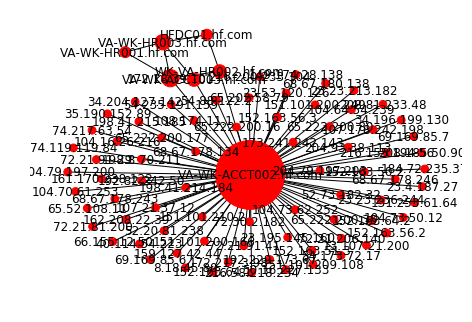

In [32]:
plt.show()